# Task 3 - Yolo and Faster-R-CNN for Object Detection and Segmentation

## Imports

In [246]:
# Standard libraries
import os
import sys
import json
import ast
import pickle
import warnings

# Numerical and data manipulation libraries
import numpy as np
import pandas as pd
from collections import Counter
from scipy.optimize import linear_sum_assignment
from sklearn.cluster import KMeans

# Torch and related libraries
import torch
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
from torchvision.transforms import Compose, ToTensor

# Ultralytics for YOLO
import ultralytics
from ultralytics import YOLO

# Image processing libraries
import cv2
from PIL import Image

# Visualization libraries
import matplotlib.pyplot as plt
from IPython.display import display, Image
from tqdm import tqdm

# Suppress all UserWarning messages
warnings.filterwarnings("ignore", category=UserWarning)

# Seed for reproducibility
np.random.seed(42)

## Image Functions

In [247]:
# Load an image from a file path
def LoadImage(path):
    return cv2.imread(path)

# Display an image already loaded in memory (as a numpy array)
def RenderImage(image, scale=1):
    
    if image.dtype == np.float64:
        image = cv2.convertScaleAbs(image)
        
    if len(image.shape) == 3 and image.shape[2] == 3:
        if np.array_equal(image[:, :, 0], image[:, :, 2]):
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    if scale != 1:
        new_size = (int(image.shape[1] * scale), int(image.shape[0] * scale))
        image = cv2.resize(image, new_size, interpolation=cv2.INTER_LINEAR)

    img_bytes = cv2.imencode('.jpg', image)[1].tobytes()
    display(Image(data=img_bytes))

## Bounding Box Functions

In [248]:
# Draw bounding boxes on an image as green rectangles
def DrawBBOnImage(img, bbs):
    img = img.copy()
    for bb in bbs:
        x1, y1, x2, y2 = [int(x) for x in bb]
        img = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 1)
    return img

# Display an image with bounding boxes
def DisplayBBResults(img_path, bbs, scale=2):
    RenderImage(DrawBBOnImage(LoadImage(img_path), bbs), scale)

# Model Loading Functions

In [249]:
# Load a YOLO model from a file (trained on full Lego dataset - 5 epochs)
def LoadYoloModel():
    return YOLO('models/trained_yolo.pt')

# Load a Faster R-CNN model from a file (trained on full Lego dataset - 5 epochs)
def LoadFRCNNModel():
    def get_model(num_classes):
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        return model

    num_classes = 2 # 1 class (lego) + background
    model = get_model(num_classes)
    model.load_state_dict(torch.load('models/trained_faster.pth', map_location=torch.device('cpu')))
    model.eval() # Set model to evaluation mode (no training)
    return model

## Model Execution Functions

In [250]:
# Make a prediction using a YOLO model and return the bounding boxes of detected legos
def RunModelYolo(model, image_path, conf=0.25):
    results = model(image_path, conf=conf, verbose=False)
    bounding_boxes = results[0].boxes.xyxy.tolist()
    return bounding_boxes

# Make a prediction using a Faster R-CNN model and return the bounding boxes of detected legos
def RunModelFRCNN(model, image_path, conf=0.5):
    
    def predict(model, image_path):
        image = LoadImage(image_path)
        image_tensor = F.to_tensor(image).unsqueeze(0)
        with torch.no_grad():
            prediction = model(image_tensor)
        return prediction

    prediction = predict(model, image_path)[0]

    # Draw boxes on the image
    boxes = prediction['boxes']
    scores = prediction['scores']
    
    bounding_boxes = []

    for box, score in zip(boxes, scores):
        box = [int(i) for i in box.tolist()]
        if score > conf:
            bounding_boxes.append(box)

    return bounding_boxes

## Image Segmentation Functions

In [251]:
# Get all images contained by each given bounding box
def GetBBImages(image, bbs):
    bb_imgs = []
    for bb in bbs:
        x1, y1, x2, y2 = [int(x) for x in bb]
        cropped = image[y1:y2, x1:x2]
        bb_imgs.append(cropped)
    return bb_imgs

# Get the mask for the lego on the given image
def GetLegoMask(image):
    mask = np.zeros(image.shape[:2], np.uint8)
    return mask

def GetGrabCutMask(img):
    mask = np.zeros(img.shape[:2], np.uint8)
    bgModel = np.zeros((1, 65), np.float64)
    fgModel = np.zeros((1, 65), np.float64)
    rect = (0, 0, img.shape[1] - 1, img.shape[0] - 1)
    iterCount = 10
    cv2.grabCut(img, mask, rect, bgModel, fgModel, iterCount, cv2.GC_INIT_WITH_RECT)
    mask = np.where((mask == cv2.GC_FGD) | (mask == cv2.GC_PR_FGD), 1, 0).astype('uint8')
    return mask

# Apply image segmentation to single lego on an bb image
def ApplyLegoSegmentation(lego_img, showIntermediateImgs=False):
    
    if showIntermediateImgs:
        RenderImage(lego_img, 5)
    
    def reduce_colors_mean_shift(img, spatial_radius, color_radius):
        lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
        shifted_img = cv2.pyrMeanShiftFiltering(lab_img, spatial_radius, color_radius)
        return cv2.cvtColor(shifted_img, cv2.COLOR_Lab2BGR)
    
    spatial_radius = 50
    color_radius = 5
    lego_img = reduce_colors_mean_shift(lego_img, spatial_radius, color_radius)

    bbColorBlurQnt = 1

    fg_mask = np.zeros(lego_img.shape[:2], np.uint8)
    
    while fg_mask.sum() == 0:
        lego_img_blurred = cv2.GaussianBlur(lego_img, (bbColorBlurQnt, bbColorBlurQnt), 0)
        fg_mask = GetGrabCutMask(lego_img)
        bbColorBlurQnt -= 2
        if bbColorBlurQnt < 1 and fg_mask.sum() == 0:
            print('Failed to mask image')
            
            # return a full mask
            return np.ones(lego_img.shape[:2], np.uint8)
    
    if showIntermediateImgs:
        masked = cv2.bitwise_and(lego_img_blurred, lego_img_blurred, mask=fg_mask)
        RenderImage(masked, 5)
        
        # Render fg_mask as binary
        RenderImage(fg_mask * 255, 5)
    
    return fg_mask

# Apply image segmentation to an image using the given bounding boxes
def ApplyImageSegmentation(image, bbs, showIntermediateImgs=False):
    bb_imgs = GetBBImages(image, bbs)
    masks = [ApplyLegoSegmentation(box_img, showIntermediateImgs) for box_img in bb_imgs]
    
    new_image = image.copy()
    
    for mask, bb in zip(masks, bbs):
        x1, y1, x2, y2 = [int(x) for x in bb]
        
        # Apply the neon effect to the bounding box
        for y in range(y1, y2):
            for x in range(x1, x2):
                if mask[y - y1, x - x1]:
                    neon = (new_image[y, x] + [255, 0, 255] ) / 2
                    new_image[y, x] = np.uint8(neon)
        
    RenderImage(new_image, 3)
    

## Model Evaluation Functions

In [252]:
df_gt = pd.read_csv('../data/values.csv') # Load the ground truth values

# Get all image IDs in the ground truth dataset
def GetAllFileNamesInDir(dir):
    file_names = []
    for filename in os.listdir(dir):
        if os.path.isfile(os.path.join(dir, filename)):
            file_names.append(filename)
    return file_names

# Get the ground truth bounding boxes for a given image ID
def GetGroundTruthBBs(image_id):
    global df_gt
    bbs_normalized = ast.literal_eval(df_gt[df_gt['id'] == image_id]['bb_list'].values[0])
    bbs = [[i*224 for i in bb] for bb in bbs_normalized] 
    return bbs

## Example Execution - Detection

Faster R-CNN:


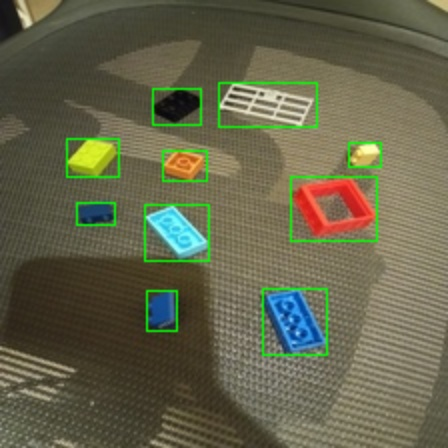

YOLO:


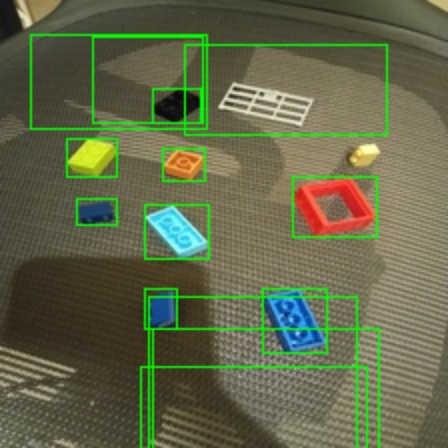

In [253]:
name = '10_1.jpg'
test_image = '../data/imgs/' + name

model_faster = LoadFRCNNModel()
model_yolo = LoadYoloModel()

bbs_faster = RunModelFRCNN(model_faster, test_image)
bbs_yolo = RunModelYolo(model_yolo, test_image)

print('Faster R-CNN:')
DisplayBBResults(test_image, bbs_faster)
print('YOLO:')
DisplayBBResults(test_image, bbs_yolo)

## Example Execution - Segmentation

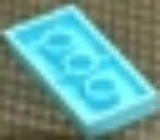

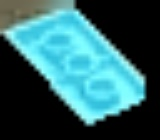

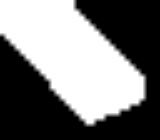

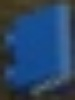

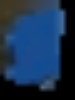

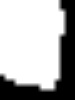

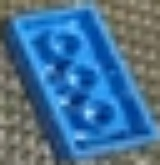

Failed to mask image


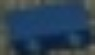

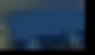

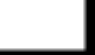

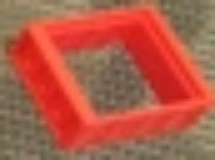

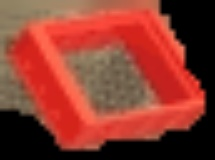

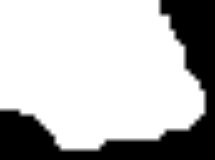

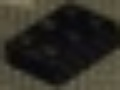

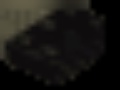

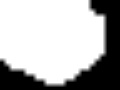

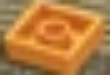

Failed to mask image


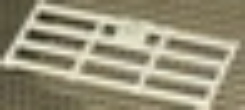

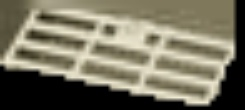

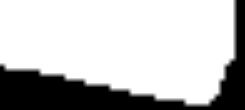

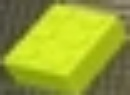

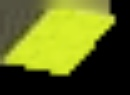

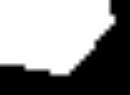

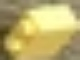

Failed to mask image


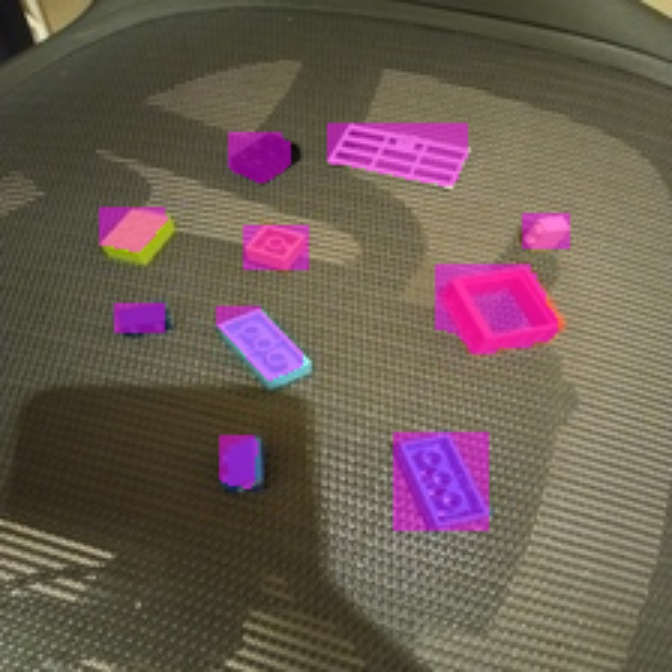

In [254]:
ApplyImageSegmentation(LoadImage(test_image), bbs_faster, True)